In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to C:\Users\Archit
[nltk_data]     Saxena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting=3)
print(f"Dataset shape: {data.shape}")



Dataset shape: (3150, 5)


In [86]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [87]:
# Column names
print(f"Feature nmaes : {data.columns.values}")


Feature nmaes : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [88]:
# Check for null values 
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [89]:
#Getting the record where 'verified_reviews' is null
data[data['verified_reviews'].isnull() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [90]:
# We will drop the null record

data.dropna(inplace=True)

In [91]:
print(f"Dataset shape after dropping null values: {data.shape}")

Dataset shape after dropping null values: (3149, 5)


In [92]:
# Creating a new column 'length' that will contain the length of the string in 'verified_reviews'
data['length'] = data['verified_reviews'].apply(len)

In [93]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [94]:
# Randomly checking for 10th record
print(f"'verified_reviews' column value :{data.iloc[10]['verified_reviews']}") # Original value
print(f"'length' column value :{len(data.iloc[10]['verified_reviews'])}") # Length of the string in 'verified_reviews'
print(f"'length' column value :{data.iloc[10]['length']}")#value of the column 'length'

'verified_reviews' column value :"I sent it to my 85 year old Dad, and he talks to it constantly."
'length' column value :65
'length' column value :65


In [95]:
# Datatype of the feature
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

Analyzing 'rating'column

In [96]:
len(data)

3149

In [97]:
# distinct values of 'rating' and its count

print(f"Rating value count:\n{data['rating'].value_counts()}")

Rating value count:
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


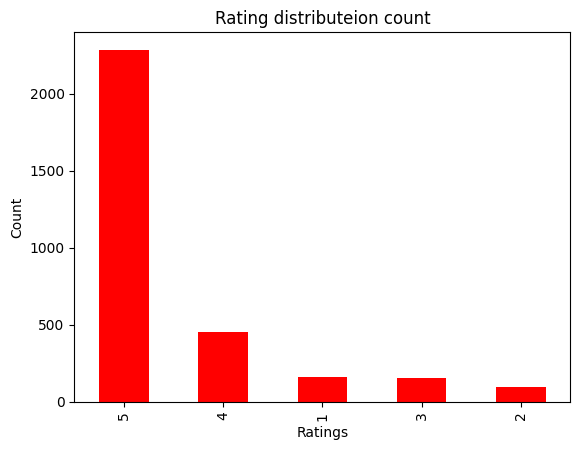

In [98]:
data['rating'].value_counts().plot.bar(color= 'red')
plt.title('Rating distributeion count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [99]:
# Finding the percentage distribution of each rating - we will divide the number of records for each rating by total number of records
print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


Let's plot the above values in a pie chart


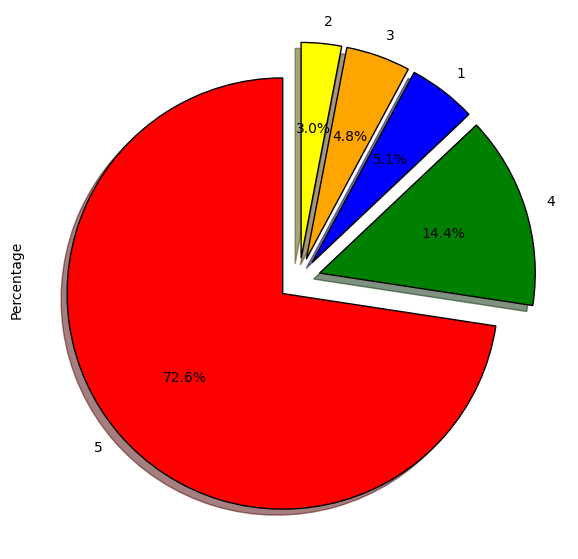

In [100]:
fig = plt.figure(figsize=(7,7))
colors = ('red' , 'green', 'blue', 'orange', 'yellow')
wp = {'linewidth': 1, 'edgecolor': 'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1, 0.1, 0.1, 0.1, 0.1) # explode all the slices
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format='png')


Analyzing the feedback column

this column refer to the feedback of the verified review

In [101]:
# distinct values of 'feedback' and its count
print(f"Feedback value count:\n{data['feedback'].value_counts()}")

Feedback value count:
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback'present-0 and 1. lets see what kind of review each values corresponds to.

feedback value = 0

In [102]:
# Extracting the 'verified_reviews' value for one record withfeedback = 0 

review_0 = data[data['feedback']==0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [103]:
# Extracting the  verified_reviews' value for one record with feedback = 1
review_1 = data[data['feedback']==1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback 0 is negative review and 1 is positive review

lets plot the feedback value count in a bar graph

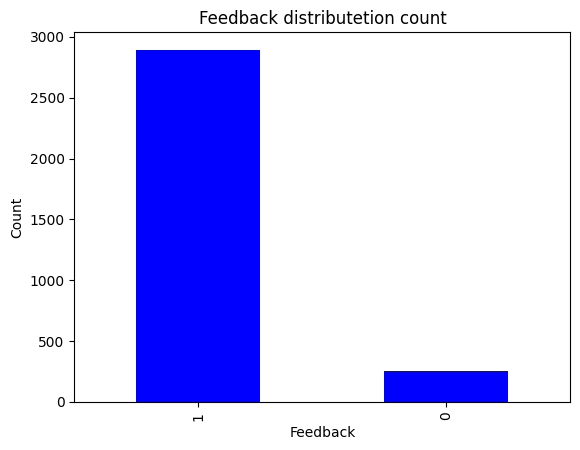

In [104]:
#Bar graph to visualize the total counts of each feedback
data['feedback'].value_counts().plot.bar(color= 'blue')
plt.title('Feedback distributetion count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [105]:
# Finding the percentage distribution of each feedback - we'll divide the number of each feedback by total number of records
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


Feedback distribution

  . 91.87% reviews are positive
  
  . 8.13% reviews are negstive

<Axes: ylabel='Percentage wise distribution of feedback '>

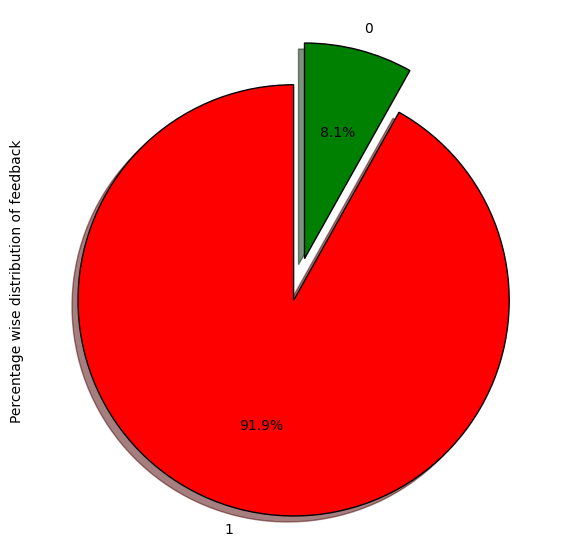

In [106]:
fig = plt.figure(figsize=(7,7))
colors = ('red','green')
wp = {'linewidth': 1, 'edgecolor': 'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode = (0.1, 0.1)  # match the number of slices
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distribution of feedback ')

In [107]:
#feedback = 0
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [108]:
#feedback = 0
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

if rating of a review is 1 or 2 then the feedback is 0 (negative)and if the rating is 3,4 or 5 then the feedback is 1 (positive).

Analyzing 'variation'column

this column refer to the variation or type of Amazon Alexa product.Example - black Dot, Charcoal frabric etc. 

In [109]:
# Distinct values of 'variation' and its count

print(f"variation value count: \n{data["variation"].value_counts()}")

variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


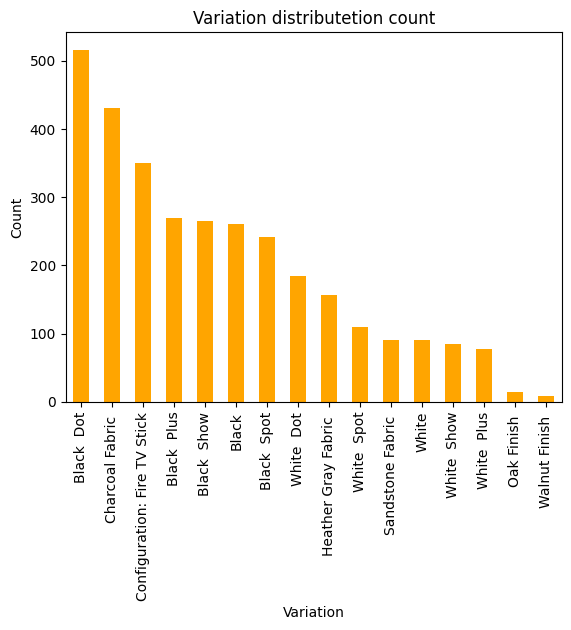

In [110]:
data['variation'].value_counts().plot.bar(color= 'orange')
plt.title('Variation distributetion count')
plt.xlabel('Variation') 
plt.ylabel('Count')
plt.show()


In [111]:
# finding the percentage distribution of each variation - we'll divide the number of each variation by total number of records
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


Mean rating according to variation

In [112]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Lets analyze the above rating


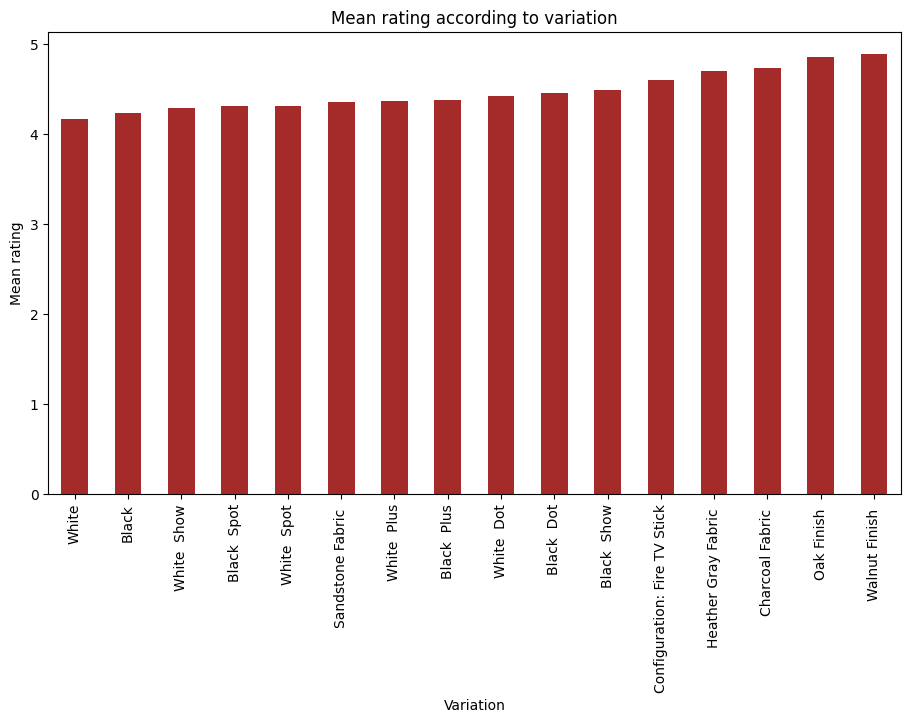

In [113]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='brown',figsize=(11,6))
plt.title('Mean rating according to variation')
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

Analyzing 'verified_reviews'column

This column contains the textual review given by the user for a variation for the product.


In [114]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

length analysis for full dataset


[Text(0.5, 1.0, 'Distribution of length of review ')]

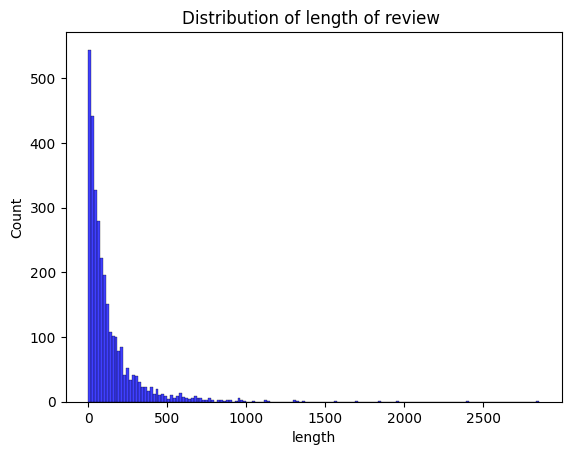

In [115]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

length analysis when feedback is 0(negative)

[Text(0.5, 1.0, 'Distribution of length of review when feedback is 0')]

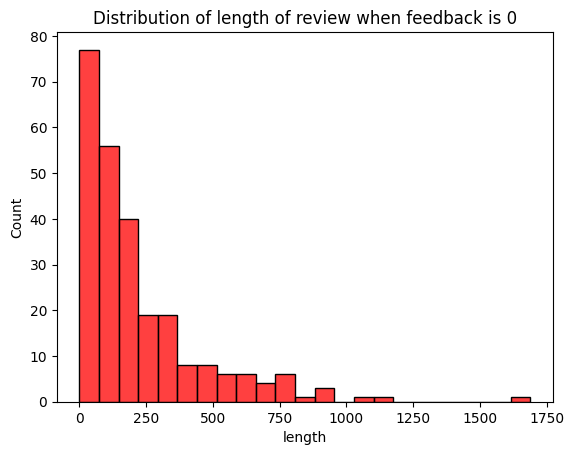

In [116]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review when feedback is 0')

Length analysis when feedback is 1(positive)


[Text(0.5, 1.0, 'Distribution of length of review when feedback is 1')]

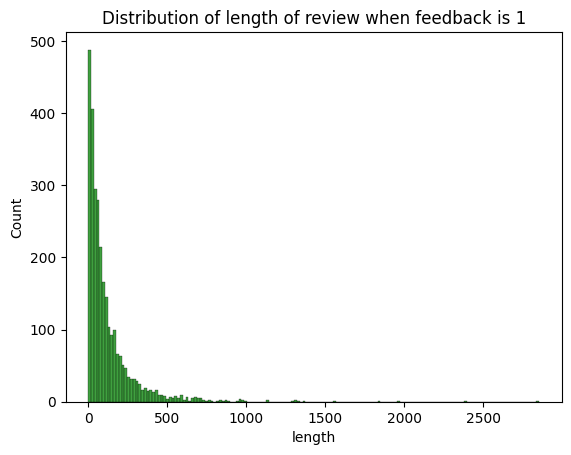

In [117]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review when feedback is 1')

Lengthwise mean rating

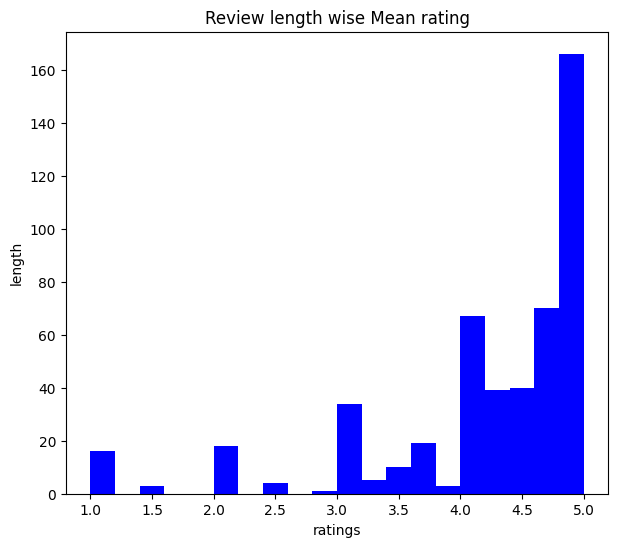

In [118]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue',figsize=(7,6),bins = 20)
plt.title("Review length wise Mean rating")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [119]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])

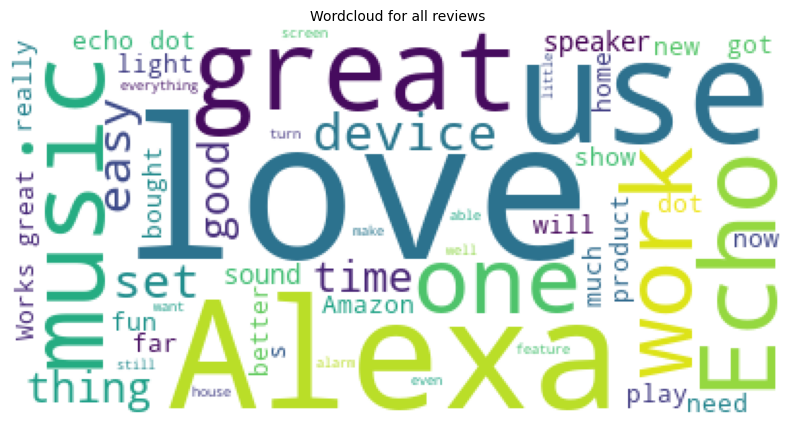

In [120]:
# combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

#initialize the word cloud object
wc = WordCloud(background_color='white', max_words=50)

#Generator and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize =10)
plt.axis('off')
plt.show()

Let's find the unique wprds in each feedback category

In [121]:
# combine all reviews where feedback category and splitting then into individual words
neg_reviews = " ".join([review for review in data['verified_reviews'][data['feedback']==0]])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data['verified_reviews'][data['feedback']==1]])
pos_reviews = pos_reviews.lower().split()

# finding wprds from review which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

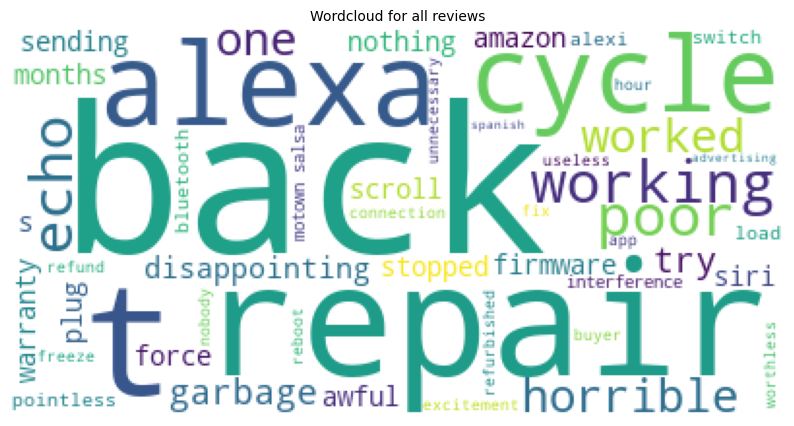

In [122]:
wc = WordCloud(background_color='white', max_words=50)

#Generator and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for all reviews', fontsize =10)
plt.axis('off')
plt.show()

Negative words ccan be see in the above word cloud - garbage, pointless, poor, horrible, repair etc

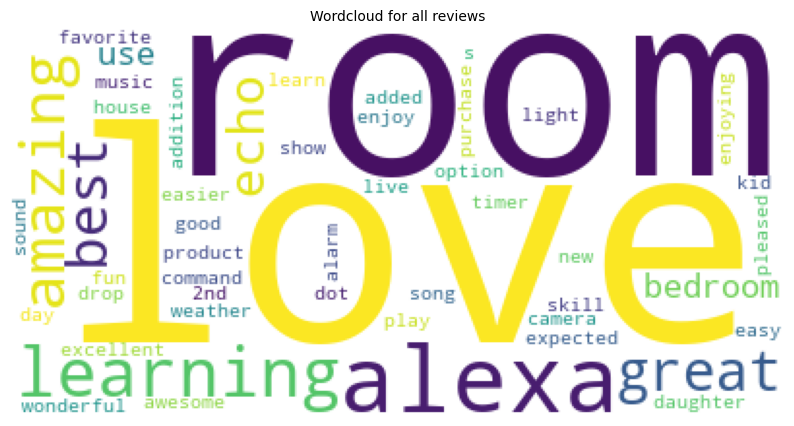

In [123]:
wc = WordCloud(background_color='white', max_words=50)

#Generator and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for all reviews', fontsize =10)
plt.axis('off')
plt.show()

positive words can be seen in the above words cloud good, enjoying, amazing, best, great etc

Preprocessing and Modeling

to build the cropus from the 'verified_reviews' we perform the following

1. Replace any non alphabet character with a space

2. Convert to lower case and split into words 

3. iterate over the individual words and if it is not a stopword then add the stemmed form of the the word to the cropus 

In [124]:
corpus = []
stemmer = PorterStemmer()
for i in range(0,data.shape[0]):
    review = re.sub('[^a-zA-Z]',' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word)for  word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag  of words

In [125]:
cv = CountVectorizer(max_features = 2500)

#storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
Y = data ['feedback'].values

In [126]:
#saving the count Vectorizer

pickle.dump(cv, open('Models/CountVectorizer.pkl', 'wb'))

In [127]:
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (3149, 2500)
Y shape: (3149,)


In [128]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"Y train:{Y_test.shape}")
print(f"X test: {X_test.shape}")
print(f"Y test: {Y_test.shape}")



X train: (2204, 2500)
Y train:(945,)
X test: (945, 2500)
Y test: (945,)


In [129]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [130]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [131]:
# saving the scaler model
pickle.dump(cv,open('Models/countVectorizer.pkl', 'wb'))

In [132]:
print(f"X shape:{X.shape}")
print(f"y shape:{Y.shape}")

X shape:(3149, 2500)
y shape:(3149,)


splitting data into train and test set with 30% data with testing

In [133]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.3, random_state = 15)
print(f"X trsin: {X_train.shape}")
print(f"Y train: {Y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"Y test: {Y_test.shape}")

X trsin: (2204, 2500)
Y train: (2204,)
X test: (945, 2500)
Y test: (945,)


In [134]:
print(f"X train max value:{X_train.max()}")
print(f"X test max value:{X_test.max()}")

X train max value:12
X test max value:10


well scale X_train and X_test so that all value are between 0 and 1

In [135]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [136]:
#saving the scaler model
pickle.dump(scaler,open('Models/scaler.pkl', 'wb'))

Random Forest

In [137]:
#fitting scaled X_train and Y_train into RandomForestClassifier model
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [138]:
# Accuracy of the model on training and testing data
print(f"Training accuracy: {model_rf.score(X_train_scl, Y_train)}")
print(f"Testing accuracy: {model_rf.score(X_test_scl, Y_test)}")

Training accuracy: 0.9941016333938294
Testing accuracy: 0.946031746031746


In [139]:
#Predicting on test set
Y_preds = model_rf.predict(X_test_scl)

In [140]:
#C0nfusion matrix
cm = confusion_matrix(Y_test, Y_preds)

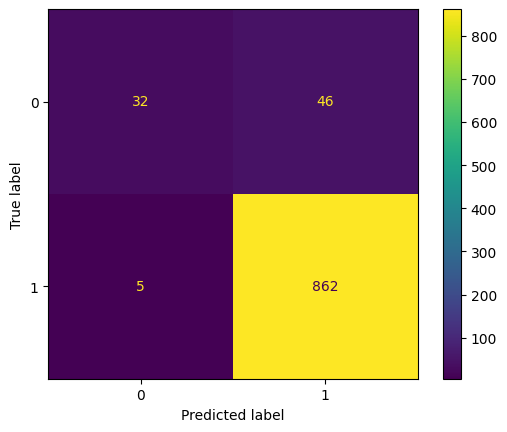

In [141]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

k fold cross-validation

In [142]:
accuracies = cross_val_score(estimator=model_rf, X=X_train_scl, y=Y_train, cv= 10)

print("Accuracy : ", accuracies.mean())
print("Standard Deviation : ", accuracies.std())

Accuracy :  0.9324002468120115
Standard Deviation :  0.006512861968748603


Applying grid search to get the optimal parameter on random forest

In [143]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators':[100, 300]
}

In [144]:
cv_oblect = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator= model_rf, param_grid=params, cv=cv_oblect, verbose=0, return_train_score= True )
grid_search.fit(X_train_scl, Y_train.ravel())

,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [True], 'max_depth': [80, 100], 'min_samples_split': [8, 12], 'n_estimators': [100, 300]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


In [145]:
#getting the best parameters after applying grid search
print(" Best Parameters Combination : {}".format(grid_search.best_params_))

 Best Parameters Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [146]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(Y_test, Y_preds))

Cross validation mean accuracy on train set : 96.80694192377496
Cross validation mean accuracy on test set : 92.18466424682396
Accuracy score for test set : 0.946031746031746


XgBoost


In [147]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, Y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [148]:
#Accuracy of the model on training and testing data
print("Training Accuracy :", model_xgb.score(X_train_scl, Y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, Y_test))

Training Accuracy : 0.9718693284936479
Testing Accuracy : 0.9375661375661376


In [149]:
Y_preds = model_xgb.predict(X_test)

In [150]:
# Confusion Matrix
cm = confusion_matrix(Y_test,Y_preds)
print(cm)

[[ 35  43]
 [ 18 849]]


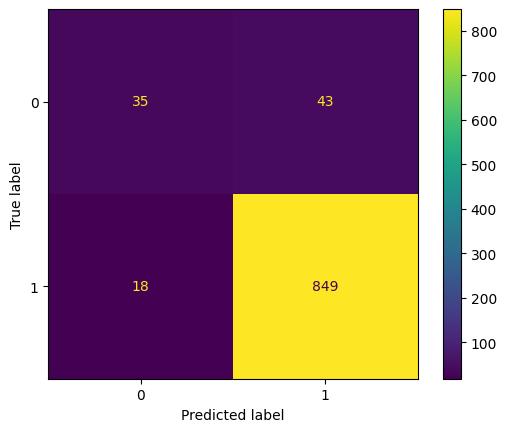

In [151]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [152]:
#Saving the XGBoost classifier
pickle.dump(model_xgb,open('Models/model_xgb.pkl','wb'))

Decision tree classifier

In [153]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, Y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [154]:
#Accuracy of the model on training and testing data
print("Training Accuracy :", model_dt.score(X_train_scl, Y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, Y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9195767195767196


In [155]:
Y_preds = model_dt.predict(X_test_scl)

In [156]:
#Confusion Matrix
cm = confusion_matrix(Y_test, Y_preds)
print(cm)

[[ 44  34]
 [ 42 825]]


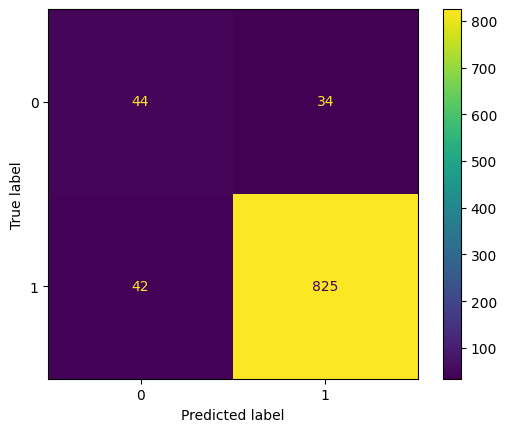

In [157]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [158]:
#saving the XGBoost classifier
pickle.dump(model_dt, open('Models/model_dt.pkl', 'wb'))

Decision tree classifier

In [159]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, Y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [160]:
#Accuracy of the model on training and testing data
print("Training Accuracy :", model_dt.score(X_train_scl, Y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, Y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9185185185185185


In [161]:
Y_preds = model_dt.predict(X_test_scl)

In [162]:
# Confusion Matrix
cm = confusion_matrix(Y_test, Y_preds)
print(cm)

[[ 45  33]
 [ 44 823]]


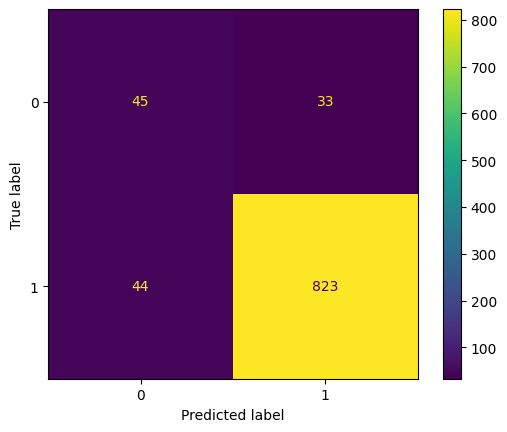

In [163]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()   
plt.show()